# Data Augmentation
train accuracy는 높게 나오지만, validation accuracy가 낮게 나온다면 ? `과적합`

: 모델이 검증 데이터셋에 대해 테스트할 때 이전에 보지 못한 것들에 위해 혼란스러워하고 있다. 새로운 데이터를 바라볼 때 모델을 더 견고하게 하기 만들기 위해, 데이터셋의 크기와 변동성을 늘리는 것을 `"데이터 증강"`이라고 한다.

size의 증가는 모델이 훈련 중에 학습할 수 있는 이미지 수를 늘려준다. variance의 증가는 모델이 중요하지 않은 특징을 무시하고 중요한 특징만 선택하도록 도와 일반화 능력을 향상시킨다.


## 3a.1 Objectives

* Augment the ASL dataset
* Use the augmented data to train an improved model
* Save the well-trained model to disk for use in deployment

In [1]:
import torch.nn as nn
import pandas as pd
import torch
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as transforms
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

## 3a.2 Preparing the Data

In [2]:
IMG_HEIGHT = 28
IMG_WIDTH = 28
IMG_CHS = 1
N_CLASSES = 24

train_df = pd.read_csv("./data/sign_mnist_train.csv")
valid_df = pd.read_csv("./data/sign_mnist_valid.csv")

class MyDataset(Dataset):
    def __init__(self, base_df):
        x_df = base_df.copy()
        y_df = x_df.pop('label')
        x_df = x_df.values / 255  # Normalize values from 0 to 1
        x_df = x_df.reshape(-1, IMG_CHS, IMG_WIDTH, IMG_HEIGHT)
        self.xs = torch.tensor(x_df).float().to(device)
        self.ys = torch.tensor(y_df).to(device)

    def __getitem__(self, idx):
        x = self.xs[idx]
        y = self.ys[idx]
        return x, y

    def __len__(self):
        return len(self.xs)

n = 32
train_data = MyDataset(train_df)
train_loader = DataLoader(train_data, batch_size=n, shuffle=True)
train_N = len(train_loader.dataset)

valid_data = MyDataset(valid_df)
valid_loader = DataLoader(valid_data, batch_size=n)
valid_N = len(valid_loader.dataset)

## 3a.3 Model Creation

* `__init__`: defines any properties we want our module to have, including our neural network layers. We will effectively be using a model within a model.
* `forward`: defines how we want the module to process any incoming data from the previous layer it is connected to. Since we are using a `Sequential` model, we can pass the input data into it like we are making a prediction.

In [3]:
n_classes = 24
kernel_size = 3
IMG_CHS = 1  # grayscale

# flattened_img_size = 75 * 3 * 3

In [4]:
class MyConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, dropout_p):
        kernel_size = 3
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size, stride=1, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.MaxPool2d(2, stride=2)
        )

    def forward(self, x):
        return self.model(x)

In [5]:
flattened_img_size = 75 * 3 * 3

# Input 1 x 28 x 28
base_model = nn.Sequential(
    MyConvBlock(IMG_CHS, 25, 0), # 25 x 14 x 14
    MyConvBlock(25, 50, 0.2), # 50 x 7 x 7
    MyConvBlock(50, 75, 0),  # 75 x 3 x 3
    # Flatten to Dense Layers
    nn.Flatten(),
    nn.Linear(flattened_img_size, 512),
    nn.Dropout(.3),
    nn.ReLU(),
    nn.Linear(512, N_CLASSES)
)

In [6]:
loss_function = nn.CrossEntropyLoss()
optimizer = Adam(base_model.parameters())

model = base_model.to(device)
model

Sequential(
  (0): MyConvBlock(
    (model): Sequential(
      (0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0, inplace=False)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (1): MyConvBlock(
    (model): Sequential(
      (0): Conv2d(25, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (2): MyConvBlock(
    (model): Sequential(
      (0): Conv2d(50, 75, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(75, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0, 

## 3a.4 Data Augmentation

First, let's get a sample image to test with:

In [7]:
row_0 = train_df.head(1)
y_0 = row_0.pop('label')
x_0 = row_0.values / 255
x_0 = x_0.reshape(IMG_CHS, IMG_WIDTH, IMG_HEIGHT)
x_0 = torch.tensor(x_0)
x_0.shape

torch.Size([1, 28, 28])

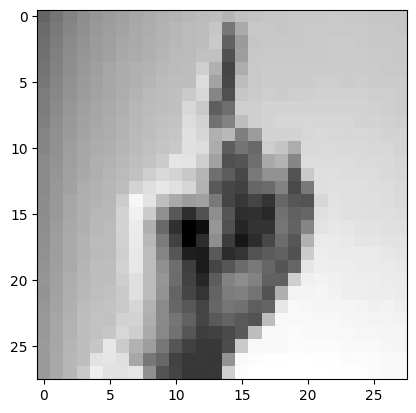

In [8]:
image = F.to_pil_image(x_0)
plt.imshow(image, cmap='gray')

### 3a.4.1 [RandomResizeCrop](https://pytorch.org/vision/0.9/transforms.html#torchvision.transforms.RandomResizedCrop)

This transform will randomly resize the input image based on scale, and then crop it to a size we specify. In this case, we will crop it to the original image dimensions. To do this, TorchVision needs to know the aspect ratio of the image it is scaling. Since our height is the same as our width, our aspect `ratio` is 1:1.

In [9]:
trans = transforms.Compose([
    transforms.RandomResizedCrop((IMG_WIDTH, IMG_HEIGHT), scale=(.7, 1), ratio=(1, 1)),
])

아래 코드를 여러번 실행시켜보면, 매번 결과가 다른 것을 볼 수 있다

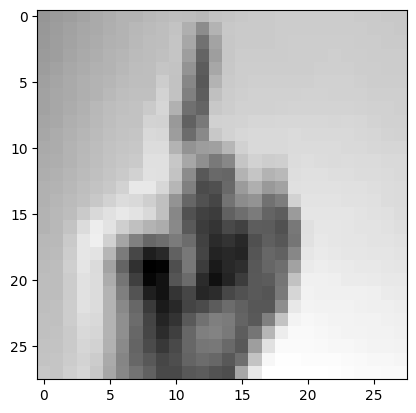

In [10]:
new_x_0 = trans(x_0)
image = F.to_pil_image(new_x_0)
plt.imshow(image, cmap='gray')

In [11]:
new_x_0.shape

torch.Size([1, 28, 28])

### 3a.4.2 [RandomHorizontalFlip](https://pytorch.org/vision/0.9/transforms.html#torchvision.transforms.RandomHorizontalFlip)

이미지를 무작위로 수평, 수직 방향으로 뒤집을 수도 있다.


In [12]:
trans = transforms.Compose([
    transforms.RandomHorizontalFlip()
])

우리는 수평으로만 뒤집을 것이다.

미국 수화는 왼손이나 오른손 중 하나가 주도적으로 사용될 수 있다. 그러나 거꾸로 된 상태에서 수화를 보는 것은 드물다. 이러한 도메인 특정 추론은 귀하의 딥 러닝 응용 프로그램에 대한 올바른 결정을 내리는 데 도움이 될 수 있다.

아래 코드를 여러번 실행시키면 좌우로 뒤집히는 것을 볼 수 있을 것이다.

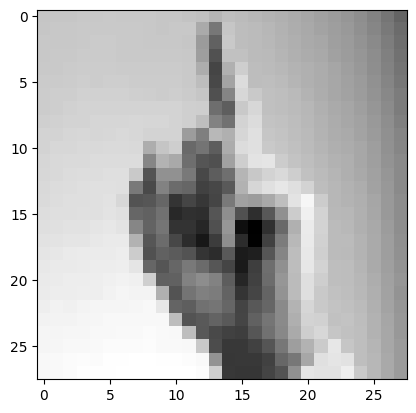

In [13]:
new_x_0 = trans(x_0)
image = F.to_pil_image(new_x_0)
plt.imshow(image, cmap='gray')

### 3a.4.3 [RandomRotation](https://pytorch.org/vision/0.9/transforms.html#torchvision.transforms.RandomRotation)

이미지에 더 많은 변동성을 추가하기 위해 무작위로 회전할 수도 있다. ASL의 경우, 너무 많이 회전하면 'D'가 'G'처럼 보이거나 그 반대가 될 수 있다. 따라서 회전을 '30'도로 제한하자.

In [14]:
trans = transforms.Compose([
    transforms.RandomRotation(10)
])

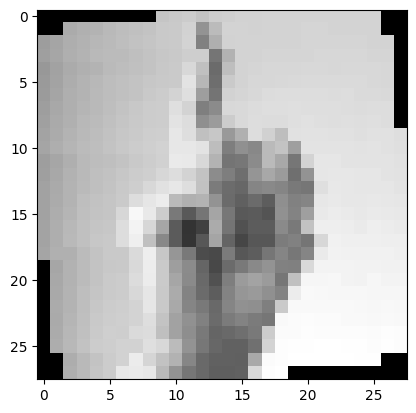

In [15]:
new_x_0 = trans(x_0)
image = F.to_pil_image(new_x_0)
plt.imshow(image, cmap='gray')

### 3a.4.4 [ColorJitter](https://pytorch.org/vision/0.9/transforms.html#torchvision.transforms.ColorJitter)

The `ColorJitter` transform has 4 arguments:
* [brightness](https://en.wikipedia.org/wiki/Brightness)
* [contrast](https://en.wikipedia.org/wiki/Contrast_(vision))
* [saturation](https://en.wikipedia.org/wiki/Colorfulness#Saturation)
* [hue](https://en.wikipedia.org/wiki/Hue)


The latter 2 apply to color images, so we will only use the first 2 for now.

In [16]:
brightness = .2  # Change to be from 0 to 1
contrast = .5  # Change to be from 0 to 1

trans = transforms.Compose([
    transforms.ColorJitter(brightness=brightness, contrast=contrast)
])

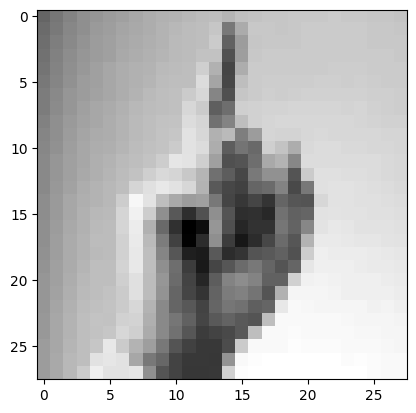

In [17]:
new_x_0 = trans(x_0)
image = F.to_pil_image(new_x_0)
plt.imshow(image, cmap='gray')

### 3a.4.5 [Compose](https://pytorch.org/vision/0.9/transforms.html#torchvision.transforms.Compose)

In [18]:
random_transforms = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.RandomResizedCrop((IMG_WIDTH, IMG_HEIGHT), scale=(.9, 1), ratio=(1, 1)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=.2, contrast=.5)
])

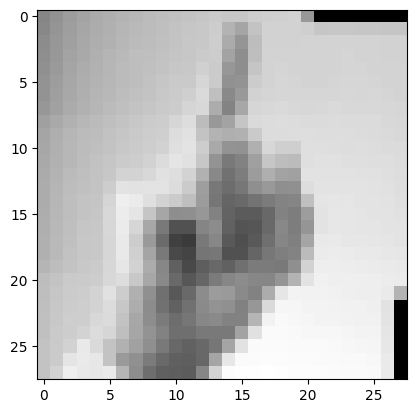

In [19]:
new_x_0 = random_transforms(x_0)
image = F.to_pil_image(new_x_0)
plt.imshow(image, cmap='gray')

## 3a.5 Training with Augmentation

Our training is mostly the same, but there is one line of change. Before passing our images to our model, we will apply our `random_transforms`. For conveneince, we moved `get_batch_accuracy` to a utils file.

In [20]:
epochs = 20
# 1) 성능 로그용 리스트
train_losses, val_losses = [], []
train_accs,   val_accs   = [], []

for epoch in range(epochs):
    # print('Epoch: {}'.format(epoch))
    train_loss, train_acc = utils.train(model, train_loader, train_N, random_transforms, optimizer, loss_function, device)
    val_loss, val_acc, cm, y_true, y_pred = utils.validate(model, valid_loader, valid_N, loss_function, device)

    # 로그에 저장
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch:2d}  "
              f"Train Loss:{train_loss:.4f} Val Loss:{val_loss:.4f}  "
              f"Val Acc:{val_acc:.4f} Acc:{train_acc:.4f}")

Epoch  0  Train Loss:657.9208 Val Loss:48.9989  Val Acc:0.9156 Acc:0.7522
Epoch  1  Train Loss:112.2503 Val Loss:29.0381  Val Acc:0.9651 Acc:0.9580
Epoch  2  Train Loss:55.6291 Val Loss:24.2561  Val Acc:0.9545 Acc:0.9791
Epoch  3  Train Loss:47.7153 Val Loss:17.4566  Val Acc:0.9780 Acc:0.9807
Epoch  4  Train Loss:28.1921 Val Loss:15.7207  Val Acc:0.9718 Acc:0.9895
Epoch  5  Train Loss:33.6846 Val Loss:18.6838  Val Acc:0.9752 Acc:0.9877
Epoch  6  Train Loss:25.0164 Val Loss:17.1853  Val Acc:0.9806 Acc:0.9909
Epoch  7  Train Loss:22.7395 Val Loss:13.7841  Val Acc:0.9791 Acc:0.9916
Epoch  8  Train Loss:20.9875 Val Loss:16.0220  Val Acc:0.9774 Acc:0.9919
Epoch  9  Train Loss:21.1233 Val Loss:20.0118  Val Acc:0.9787 Acc:0.9924
Epoch 10  Train Loss:17.8451 Val Loss:18.3451  Val Acc:0.9741 Acc:0.9933
Epoch 11  Train Loss:15.2252 Val Loss:18.7153  Val Acc:0.9695 Acc:0.9943
Epoch 12  Train Loss:18.6494 Val Loss:17.9446  Val Acc:0.9730 Acc:0.9930
Epoch 13  Train Loss:13.8078 Val Loss:10.2552  Va

## Discussion of Results

You will notice that the validation accuracy is higher, and more consistent. This means that our model is no longer overfitting in the way it was; it generalizes better, making better predictions on new data.

The training accuracy may be lower, and that's ok. Compared to before, the model is being exposed to a much larger variety of data.

## Saving the Model

Now that we have a well-trained model, we will want to deploy it to perform inference on new images.

It is common, once we have a trained model that we are happy with to save it to disk. PyTorch has [multiple ways](https://pytorch.org/tutorials/beginner/saving_loading_models.html) to do this, but for now, we will use `torch.save`. We will also need to save the code for our `MyConvBlock` custom module, which we did in [utils.py](./utils.py). In the next notebook, we'll load the model and use it to read new sign language pictures.

PyTorch cannot save a compiled model ([see this post](https://discuss.pytorch.org/t/how-to-save-load-a-model-with-torch-compile/179739)), so we will instead

In [21]:
torch.save(base_model, 'model.pth')

## Visualize Results

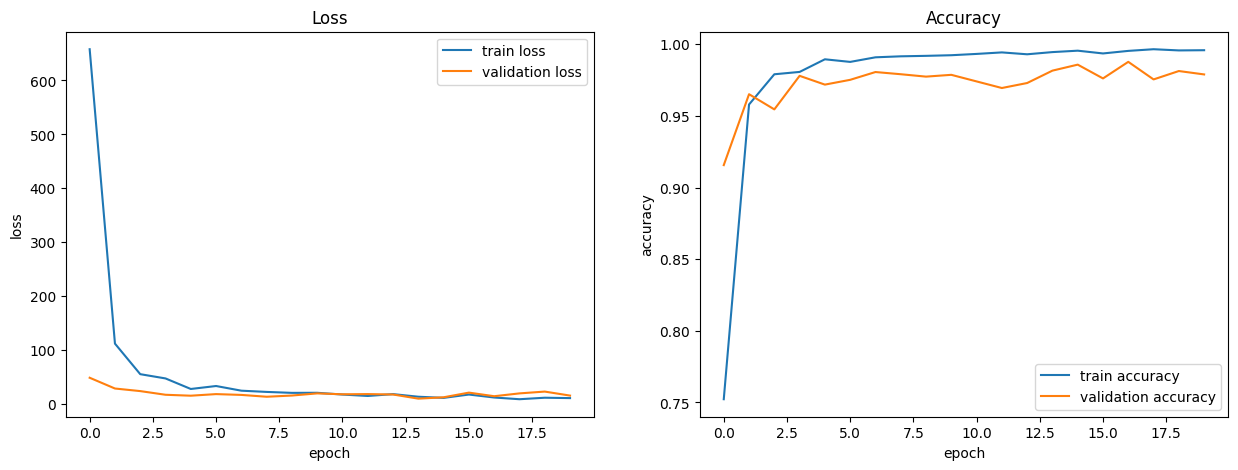

In [22]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(train_losses, label = 'train loss')
plt.plot(val_losses, label = 'validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(train_accs, label = 'train accuracy')
plt.plot(val_accs, label = 'validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.show()

In [23]:
import seaborn as sns

In [24]:
DATA_LABELS = ['A', 'B', 'C', 'D','E',
    'F', 'G', 'H', 'I', 'K',
    'L', 'M', 'N', 'O', 'P',
    'Q', 'R', 'S', 'T', 'U',
    'V', 'W', 'X', 'Y']

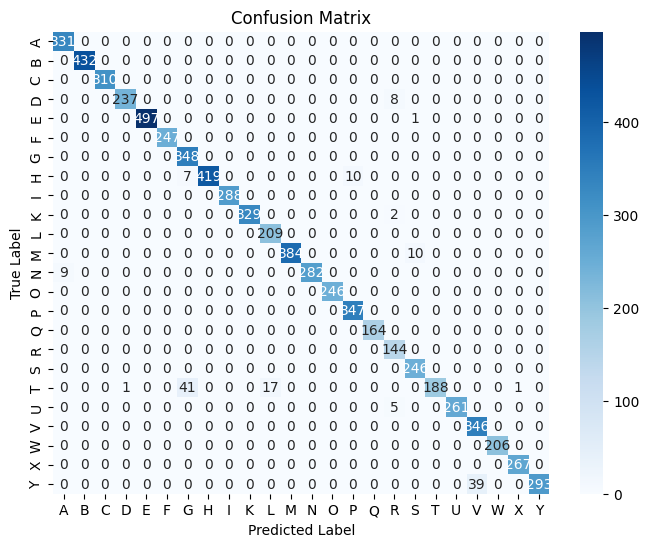

In [25]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=DATA_LABELS,
            yticklabels=DATA_LABELS)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [26]:
from sklearn.metrics import classification_report

In [27]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=DATA_LABELS))

Classification Report:
              precision    recall  f1-score   support

           A       0.97      1.00      0.99       331
           B       1.00      1.00      1.00       432
           C       1.00      1.00      1.00       310
           D       1.00      0.97      0.98       245
           E       1.00      1.00      1.00       498
           F       1.00      1.00      1.00       247
           G       0.88      1.00      0.94       348
           H       1.00      0.96      0.98       436
           I       1.00      1.00      1.00       288
           K       1.00      0.99      1.00       331
           L       0.92      1.00      0.96       209
           M       1.00      0.97      0.99       394
           N       1.00      0.97      0.98       291
           O       1.00      1.00      1.00       246
           P       0.97      1.00      0.99       347
           Q       1.00      1.00      1.00       164
           R       0.91      1.00      0.95       144
    